In [39]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('ggplot')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [40]:
from pandas.api.types import CategoricalDtype

df = pd.read_csv('results.csv')
errors_order = CategoricalDtype(["none", "single", "half"], ordered=True)
df.errors = df.errors.astype(errors_order)
df

,database,dataset,scale,variant,errors,time
0,neo4j,recommendations,1.0,full,none,1825
1,neo4j,recommendations,1.0,full,none,1327
2,neo4j,recommendations,1.0,full,none,1274
3,neo4j,recommendations,1.0,binary,none,1713
4,neo4j,recommendations,1.0,binary,none,1515
...,...,...,...,...,...,...
73,tigergraph,snb,1.0,full,none,1037
74,tigergraph,snb,1.0,full,none,1009
75,tigergraph,snb,1.0,binary,none,1009
76,tigergraph,snb,1.0,binary,none,1026


In [41]:
def format(str):
    if str.lower() == "neo4j":
        return "Neo4j"
    if str.lower() == "janusgraph":
        return "JanusGraph"
    if str.lower() == "tigergraph":
        return "TigerGraph"
    if str.lower() == "snb":
        return "SNB"
    return str.capitalize()

### Scale

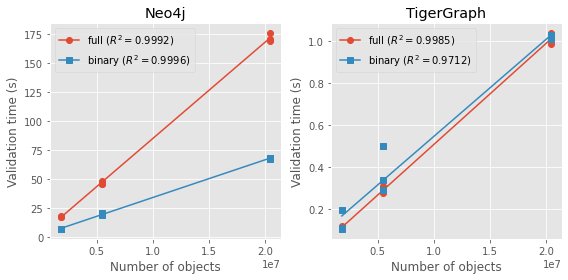

In [89]:
from sklearn.linear_model import LinearRegression

df_num_elements = pd.DataFrame([
    ["recommendations", 1.0, 28_863, 166_261, 0],
    ["snb", 0.1, 327_588, 1_477_965, 0],
    ["snb", 0.3, 908_224, 4_583_118, 0],
    ["snb", 1.0, 3_181_724, 17_256_038, 0]
], columns=["dataset", "scale", "nodes", "edges", "elements"])

df_num_elements.elements = df_num_elements.nodes + df_num_elements.edges


def plot_scale_per_db(ax, db):
    df_filtered = df[
        (df.database == db) & (df.dataset == "snb") & (df.errors == "none")
    ]
    df_merged = pd.merge(df_filtered, df_num_elements, on=["dataset", "scale"])

    full = df_merged[df_merged.variant == "full"]
    binary = df_merged[df_merged.variant == "binary"]

    X_full = np.array(full.elements).reshape(-1, 1)
    y_full = np.array(full.time).reshape(-1, 1)
    lm_full = LinearRegression().fit(X_full, y_full)
    r_sq_full = lm_full.score(X_full, y_full)
    y_full_pred = lm_full.predict(X_full)
    
    X_binary = np.array(binary.elements).reshape(-1, 1)
    y_binary = np.array(binary.time).reshape(-1, 1)
    lm_binary = LinearRegression().fit(X_binary, y_binary)
    r_sq_binary = lm_binary.score(X_binary, y_binary)
    y_binary_pred = lm_binary.predict(X_binary)

    ax.plot(full.elements, full.time / 1000, "o", color=colors[0])
    ax.plot(X_full, y_full_pred / 1000, "-", color=colors[0])

    ax.plot(binary.elements, binary.time / 1000, "s", color=colors[1])
    ax.plot(X_full, y_binary_pred / 1000, "-", color=colors[1])

    ax.set_xlabel("Number of objects")
    ax.set_ylabel("Validation time (s)")
    ax.set_title(format(db))

    # Create "proxy artists" to add to the legend
    # We want the legend to show the line with marker, while the default legend would
    handle_full = mpl.lines.Line2D([], [], color=colors[0], marker='o', label=f"full ($R^2 = {r_sq_full:.4f}$)")
    handle_binary = mpl.lines.Line2D([], [], color=colors[1], marker='s', label=f"binary ($R^2 = {r_sq_binary:.4f}$)")
    ax.legend(handles=[handle_full, handle_binary], loc="upper left")


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_scale_per_db(axs[0], "neo4j")
plot_scale_per_db(axs[1], "tigergraph")
fig.tight_layout()
fig.savefig("../docs/figures/results-scale.pdf")
plt.show()

### Error rate

0    7.381667
1    7.099333
2    6.368333
Name: time, dtype: float64
0    56.739000
1     6.873333
2     0.212000
Name: time, dtype: float64
0    0.135667
1    0.112000
2    0.146333
Name: time, dtype: float64


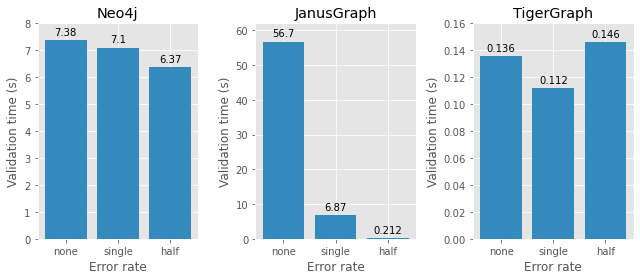

In [98]:
# TODO: measure full variant for different error rates?

def plot_errors_per_db(ax, db):
    df_filtered = df[
        (df.database == db) & (df.dataset == "snb") & (df.scale == 0.1) & (df.variant == "binary")
    ]

    data = df_filtered.groupby("errors").mean().reset_index()
    
    print(data.time / 1000)
    rects = ax.bar(data.errors, data.time / 1000, color=colors[1])
    ax.set_xlabel("Error rate")
    ax.set_ylabel("Validation time (s)")
    ax.set_title(format(db))

    ax.bar_label(rects, padding=3, fmt="%.3g")


fig, axs = plt.subplots(1, 3, figsize=(9, 4))
plot_errors_per_db(axs[0], "neo4j")
axs[0].set_ylim([0, 8])
plot_errors_per_db(axs[1], "janusgraph")
axs[1].set_ylim([0, 62])
plot_errors_per_db(axs[2], "tigergraph")
axs[2].set_ylim([0, 0.16])
fig.tight_layout()
fig.savefig("../docs/figures/results-errors.pdf")
plt.show()

In [97]:
for db in ["neo4j", "janusgraph", "tigergraph"]:
    df_filtered = df[
        (df.database == db) & (df.dataset == "snb") & (df.scale == 0.1) & (df.variant == "binary")
    ]
    
    
    none = df_filtered[df_filtered.errors == "none"].time
    single = df_filtered[df_filtered.errors == "single"].time
    half = df_filtered[df_filtered.errors == "half"].time

    print(db)
    t_stat, p_value = stats.ttest_ind(none, single)
    print(f"none vs single: t={t_stat:.2f}, p={p_value:.3g}")

    t_stat, p_value = stats.ttest_ind(single, half)
    print(f"single vs half: t={t_stat:.2f}, p={p_value:.3g}")

    t_stat, p_value = stats.ttest_ind(none, half)
    print(f"none vs half:   t={t_stat:.2f}, p={p_value:.3g}")
    print()

neo4j
none vs single: t=1.27, p=0.272
single vs half: t=3.74, p=0.0202
none vs half:   t=6.06, p=0.00375

janusgraph
none vs single: t=153.64, p=1.08e-08
single vs half: t=39.32, p=2.5e-06
none vs half:   t=203.90, p=3.47e-09

tigergraph
none vs single: t=0.82, p=0.46
single vs half: t=-1.18, p=0.304
none vs half:   t=-0.26, p=0.806



### Variant

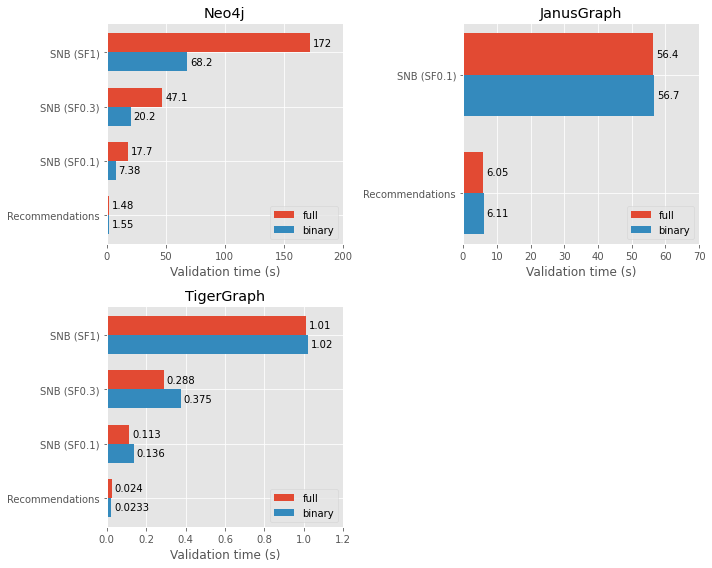

In [93]:
def generate_label(row):
    if row.dataset == "recommendations":
        return f"{format(row.dataset)}"
    else:
        return f"{format(row.dataset)} (SF{row.scale:.1g})"


def plot_dataset_scale_variant_per_db(ax, db):
    df_filtered = df[
        (df.database == db) & (df.errors == "none")
    ]

    full = df_filtered[df_filtered.variant == "full"]
    binary = df_filtered[df_filtered.variant == "binary"]
    full_means = full.groupby(["dataset", "scale"]).mean().reset_index()
    binary_means = binary.groupby(["dataset", "scale"]).mean().reset_index()
    
    labels = full_means.apply(generate_label, axis=1)
    y = np.arange(len(labels))
    width = 0.35
    
    rects1 = ax.barh(y + width/2, full_means.time / 1000, width, label="full")
    rects2 = ax.barh(y - width/2, binary_means.time / 1000, width, label="binary")
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Validation time (s)")
    ax.set_title(format(db))
    ax.legend(loc="lower right")

    ax.bar_label(rects1, padding=3, fmt="%.3g")
    ax.bar_label(rects2, padding=3, fmt="%.3g")


fig, axs = plt.subplots(2, 2, figsize=(10, 8))
plot_dataset_scale_variant_per_db(axs[0,0], "neo4j")
axs[0,0].set_xlim([0, 200])
plot_dataset_scale_variant_per_db(axs[0,1], "janusgraph")
axs[0,1].set_xlim([0, 70])
plot_dataset_scale_variant_per_db(axs[1,0], "tigergraph")
axs[1,0].set_xlim([0, 1.2])
axs[1,1].set_axis_off()
fig.tight_layout()
fig.savefig("../docs/figures/results-variant.pdf")
plt.show()

In [90]:
df_filtered = df[df.errors == "none"]
for name, group in df_filtered.groupby(["database", "dataset", "scale"]):
    full = group[group.variant == "full"]
    binary = group[group.variant == "binary"]
    t_stat, p_value = stats.ttest_ind(full.time, binary.time)
    print(f"{name} | full = {np.mean(full.time / 1000):.3f} | binary = {np.mean(binary.time / 1000):.3f} | t = {t_stat:.3g} | p = {p_value:.3g}")

('janusgraph', 'recommendations', 1.0) | full = 6.052 | binary = 6.113 | t = -0.418 | p = 0.697
('janusgraph', 'snb', 0.1) | full = 56.406 | binary = 56.739 | t = -0.555 | p = 0.608
('neo4j', 'recommendations', 1.0) | full = 1.475 | binary = 1.548 | t = -0.369 | p = 0.731
('neo4j', 'snb', 0.1) | full = 17.711 | binary = 7.382 | t = 31.3 | p = 6.19e-06
('neo4j', 'snb', 0.3) | full = 47.125 | binary = 20.175 | t = 28.9 | p = 8.56e-06
('neo4j', 'snb', 1.0) | full = 171.890 | binary = 68.166 | t = 49.9 | p = 9.69e-07
('tigergraph', 'recommendations', 1.0) | full = 0.024 | binary = 0.023 | t = 0.316 | p = 0.768
('tigergraph', 'snb', 0.1) | full = 0.113 | binary = 0.136 | t = -0.782 | p = 0.478
('tigergraph', 'snb', 0.3) | full = 0.288 | binary = 0.375 | t = -1.34 | p = 0.252
('tigergraph', 'snb', 1.0) | full = 1.010 | binary = 1.021 | t = -0.659 | p = 0.546
